# Exploration and plot generation
This notebook generates many plots based on spells and spells_21_days.

In [1]:
from collections import Counter
from itertools import chain
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import chain
from collections import Counter
import re
import seaborn as sns  # for easier grouped histogram
import numpy as np
from src.modelling.final_preprocessing import final_common_preprocessing

base = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50/")

# --- Load data ---
input_suffix = "_opioid_sample5M"
output_suffix = "_opioid_sample5M_grace15_minspell7_ae_censoring"
spells = pd.read_parquet(base / f"spells_with_labels{output_suffix}.parquet")
split_spells = pd.read_parquet(base / f"split_spells{output_suffix}.parquet")
demographics = pd.read_parquet(base / f"demographics{input_suffix}.parquet")
comorbidities = pd.read_parquet(base / f"icd10_codes_from_spells{output_suffix}_clustered.parquet")
drug_changes = pd.read_parquet(base / f"drug_changes{output_suffix}.parquet")

df, _, _ = final_common_preprocessing(split_spells, demographics, comorbidities, 30)

# # Filter out rows with len(drug_combo) < 3 (due to a bug that I was not able to fix, I suspect it is related to the GRACE PERIOD at the end of the spells)
# before_count = len(split_spells)
# split_spells = split_spells[split_spells["drug_combo"].map(len) >= 3]
# after_count = len(split_spells)
# print(f"Filtered out {before_count - after_count} rows with drug_combo length < 3, about {((before_count - after_count) / before_count) * 100:.2f}% of the data.")



dem shape:    (824793, 6)
spells shape: (1794387, 14)
icd shape:    (1231909, 4)
spells after drug_combo filter: (1581017, 14)
spells after short no-AE spell filter: (932712, 14) (removed 41.01% rows)
Number of spells with AE 17605
Number of AE within 30 days: 15387
AE within 30 days rate: 0.016497053752926948
Spells before deduplication: 932712
Spells after deduplication: 852289
Number of AE within 30 days after dedup: 15380
Merging tables...
After merging demographics, df shape: (852289, 22)
Combined df shape: (852289, 23)
Number of AE within 30 days after merge: 15380
Number of rows with NaN in birthyear: 2121
Number of rows with None in gender: 0
Filtering out 1290 rows (0.15%) where AE ICD prefix appears in icd10_codes (potential leakage).
Number of AE within 30 days after leakage filter: 14187
Rows remaining after leakage filter: 850999
Dropped 32617 rows with age > 120.
Number of AE within 30 days after dropping missing essential info: 13959
AE within 30 days rate: 0.01705682676

In [2]:
# --- 🧮 Spell summary comparison Split vs non-split---

def summarize_spells(df):
    """Get spell summary statistics."""
    total = len(df)
    one_per = len(df.drop_duplicates(subset=["MemberUID"], keep="first"))
    return total, one_per, one_per / total * 100

# Summaries
total_split, one_split, pct_split = summarize_spells(df)


print("📊 Spell Summary Comparison")
print("-" * 60)
print(f"{'Config':<20}{'Total Spells':>15}{'1/Patient':>15}{'% of Total':>10}")
print("-" * 60)
print(f"{'Split Spells':<20}{total_split:>15,}{one_split:>15,}{pct_split:>9.2f}%")
print("-" * 60)

# Keep only the one-per-patient spells for further analysis
# spells = spells.drop_duplicates(subset=["MemberUID"], keep="first")


📊 Spell Summary Comparison
------------------------------------------------------------
Config                 Total Spells      1/Patient% of Total
------------------------------------------------------------
Split Spells                818,382        207,388    25.34%
------------------------------------------------------------



📋 Top Adverse Event Codes and Descriptions
--------------------------------------------------------------------------------
CodeValue  count                                                                                         Description  % of Total
    F1120   3031                                              Mental and behavioural disorders due to use of opioids       39.46
    F1190    783                                              Mental and behavioural disorders due to use of opioids       10.19
  T7840XA    772                                                            Adverse effects not elsewhere classified       10.05
  T451X5A    584       Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances        7.60
    F1920    505  Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances        6.57
  T402X5A    496       Poisoning by adverse effect of and underdosing of drugs medicaments and biolog

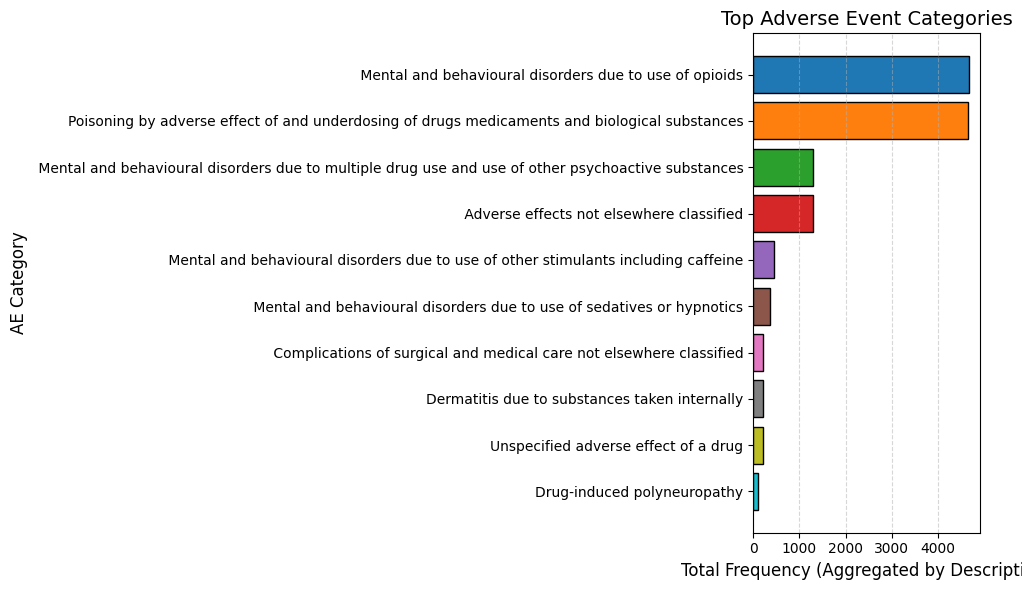


🧮 Aggregated AE Category Counts (for plot)
                                                                                        Description  count
                                             Mental and behavioural disorders due to use of opioids   4671
      Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances   4646
 Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances   1298
                                                           Adverse effects not elsewhere classified   1289
                 Mental and behavioural disorders due to use of other stimulants including caffeine    452
                              Mental and behavioural disorders due to use of sedatives or hypnotics    371
                                Complications of surgical and medical care not elsewhere classified    216
                                                      Dermatitis due to substances taken internally 

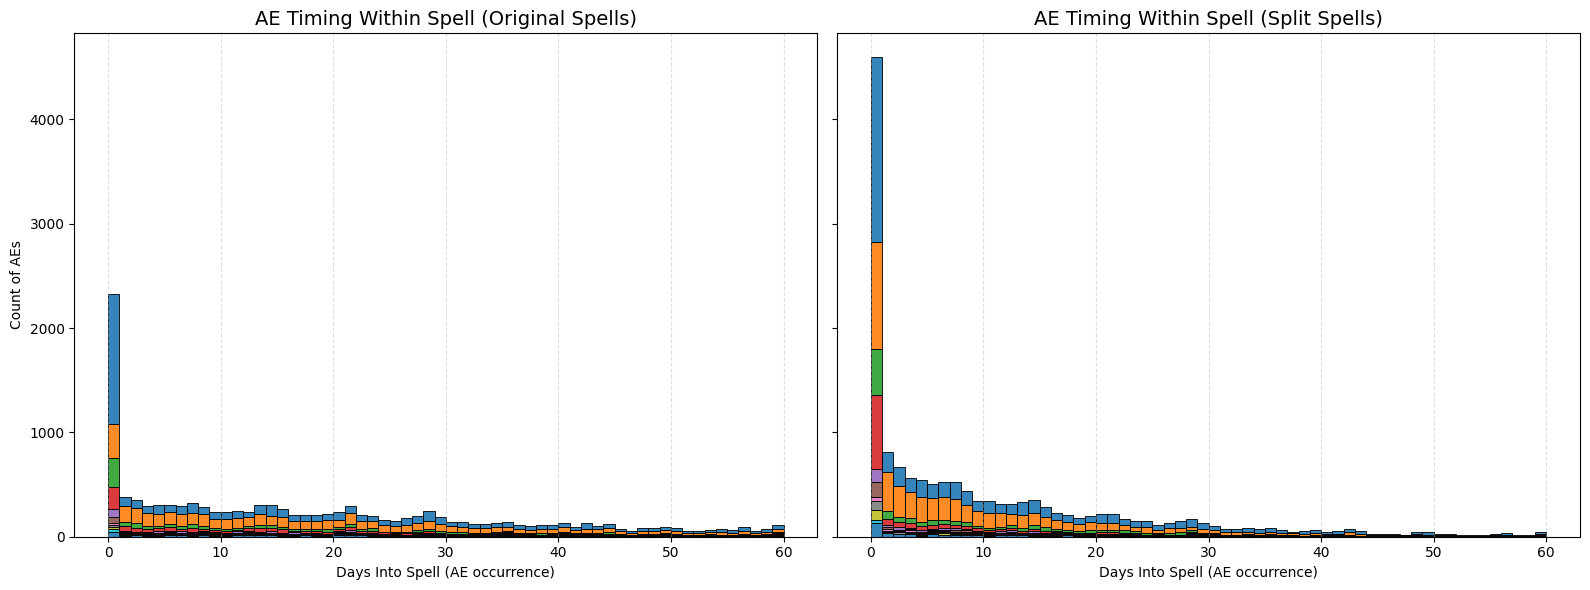

In [7]:
# --- ⚙️ Flatten AE codes across all AE spells ---
# If 'first_ae_code' doesn’t exist, replace it with your AE column (e.g. 'ae_codes')
ae_freq_df = (
    df[df["ae_within_30d"]]["first_ae_code"]
    .value_counts()
    .reset_index()
    .rename(columns={"first_ae_code": "CodeValue"})
)

# --- 📖 Read mapping CSV (with lazy SQL-like patterns) ---
ae_map = pd.read_csv("data/icd10_codes.csv")  # columns: code, description

def map_description(code):
    """Return AE description using SQL-like % wildcards."""
    for _, row in ae_map.iterrows():
        pattern = row["code"].replace("%", "")
        if str(code).startswith(pattern):
            return row["description"]
    return "Unknown AE code"

# Map descriptions
ae_freq_df["Description"] = ae_freq_df["CodeValue"].apply(map_description)

# --- 📊 Summary Table of Top AE Codes ---
top_n = 10
top_ae_df = ae_freq_df.head(top_n).copy()
top_ae_df["% of Total"] = (
    top_ae_df["count"] / top_ae_df["count"].sum() * 100
).round(2)

print("\n📋 Top Adverse Event Codes and Descriptions")
print("-" * 80)
print(top_ae_df.to_string(index=False))
print("-" * 80)
print(f"Showing top {top_n} AE categories out of {len(ae_freq_df):,} total unique codes.\n")

# --- 🔢 Aggregate by Description for visualization ---
agg_by_desc = (
    ae_freq_df.groupby("Description", as_index=False)["count"]
    .sum()
    .sort_values("count", ascending=False)
)

# Take top N descriptions for plotting
top_desc = agg_by_desc.head(top_n)

# --- 🧩 Identify top AE *descriptions* for consistent palette ---
top_n_desc = top_n
top_descriptions = top_desc["Description"].tolist()

ae_categories = top_descriptions + ["Other"]
palette_colors = sns.color_palette("tab10", n_colors=len(ae_categories))
palette_map = dict(zip(ae_categories, palette_colors))

# --- 🎨 Bar plot of top AE categories (using shared palette) ---
plt.figure(figsize=(10, 6))
bar_colors = [palette_map[d] for d in top_desc["Description"]]
plt.barh(top_desc["Description"], top_desc["count"],
         color=bar_colors, edgecolor="black")
plt.gca().invert_yaxis()  # Highest on top
plt.title("Top Adverse Event Categories", fontsize=14)
plt.xlabel("Total Frequency (Aggregated by Description)", fontsize=12)
plt.ylabel("AE Category", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()

# Save to results/plots
plt.savefig("results/plots/AE_distribution_plot.png")
plt.show()

# --- 🧮 Print small summary of aggregation ---
print("\n🧮 Aggregated AE Category Counts (for plot)")
print(top_desc.to_string(index=False))

print("Total Adverse Events Counted:", ae_freq_df["count"].sum())

# --- 🧭 AE positioning within spells and split_spells (days into spell) ---
def prepare_ae_spells(df: pd.DataFrame) -> pd.DataFrame:
    """Subset to spells with AE, ensure dates, and compute days_into_spell."""
    ae_df = df[df["had_ae"]].copy()
    ae_df["entry_date"] = pd.to_datetime(ae_df["entry_date"])
    ae_df["first_ae_date"] = pd.to_datetime(ae_df["first_ae_date"])
    ae_df["days_into_spell"] = (ae_df["first_ae_date"] - ae_df["entry_date"]).dt.days
    return ae_df

ae_spells = prepare_ae_spells(spells)
ae_spells_split = prepare_ae_spells(df)

# --- 📊 Summaries ---
print("\n📊 AE Positioning Within Spell (original spells)")
print("-" * 60)
print(ae_spells["days_into_spell"].describe())

print("\n📊 AE Positioning Within Spell (split_spells)")
print("-" * 60)
print(ae_spells_split["days_into_spell"].describe())

def add_ae_group_by_desc(df: pd.DataFrame, top_desc: list) -> pd.DataFrame:
    df = df.copy()
    # Map ICD code -> Description using the same function you used earlier
    df["AE_desc"] = df["first_ae_code"].apply(map_description)
    # Collapse rare descriptions into "Other"
    df["AE_group"] = df["AE_desc"].where(df["AE_desc"].isin(top_desc), "Other")
    return df

ae_spells = add_ae_group_by_desc(ae_spells, top_descriptions)
ae_spells_split = add_ae_group_by_desc(ae_spells_split, top_descriptions)

# --- 🎨 Plot histograms side by side with shared palette (by Description) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.histplot(
    data=ae_spells,
    x="days_into_spell",
    hue="AE_group",
    hue_order=ae_categories,
    palette=palette_map,
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9,
    ax=axes[0]
)
axes[0].set_title("AE Timing Within Spell (Original Spells)", fontsize=14)
axes[0].set_xlabel("Days Into Spell (AE occurrence)")
axes[0].set_ylabel("Count of AEs")
axes[0].grid(axis="x", linestyle="--", alpha=0.4)

sns.histplot(
    data=ae_spells_split,
    x="days_into_spell",
    hue="AE_group",
    hue_order=ae_categories,
    palette=palette_map,
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9,
    ax=axes[1]
)
axes[1].set_title("AE Timing Within Spell (Split Spells)", fontsize=14)
axes[1].set_xlabel("Days Into Spell (AE occurrence)")
axes[1].set_ylabel("Count of AEs")
axes[1].grid(axis="x", linestyle="--", alpha=0.4)

# Remove legends:
for ax in axes:
    ax.legend_.remove()

plt.tight_layout()
# Save to results/plots
plt.savefig("results/plots/AE_timing_within_spell_5M.png")
plt.show()


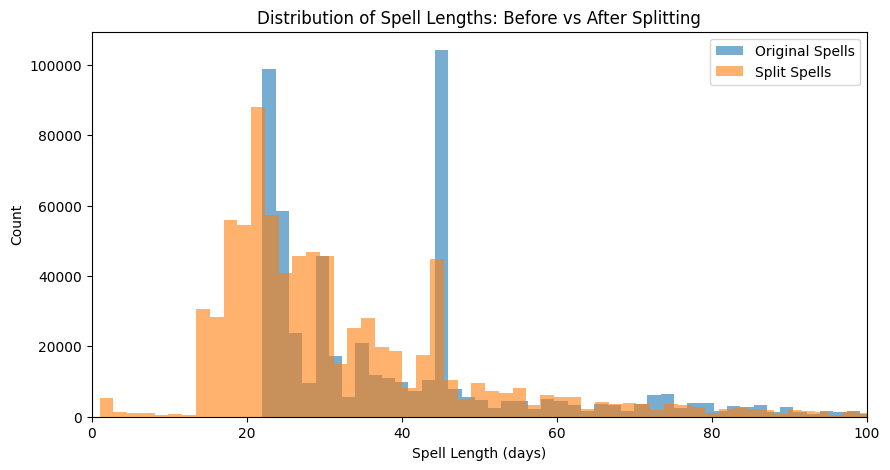

Original Spells Summary:
count    634355.000000
mean         73.972449
std         130.652432
min          22.000000
25%          26.000000
50%          42.000000
75%          61.000000
max        3448.000000
Name: spell_length_days, dtype: float64

Split Spells Summary:
count    818382.000000
mean         34.814778
std          25.708464
min           1.000000
25%          21.000000
50%          27.000000
75%          41.000000
max         889.000000
Name: spell_length_days, dtype: float64


In [ ]:
# --- 1. Distribution of spell lengths before and after splitting ---

import matplotlib.pyplot as plt

# Original spell lengths
spell_lengths = spells['spell_length_days']

# Split spell lengths
split_spell_lengths = df['spell_length_days']

# Plot
plt.figure(figsize=(10,5))
plt.hist(spell_lengths, bins=2000, alpha=0.6, label='Original Spells')
plt.hist(split_spell_lengths, bins=500, alpha=0.6, label='Split Spells')
plt.xlabel('Spell Length (days)')
plt.ylabel('Count')
plt.xlim(0, 100)  # Set x-axis limits
plt.title('Distribution of Spell Lengths: Before vs After Splitting')
plt.legend()
plt.show()

plt.savefig("results/plots/spell_lengths_before_after_splitting.png")

# Summary statistics
print("Original Spells Summary:")
print(spell_lengths.describe())
print("\nSplit Spells Summary:")
print(split_spell_lengths.describe())


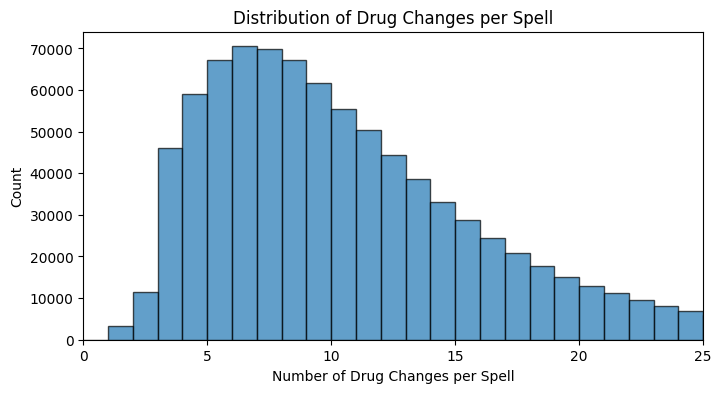

count    888368.000000
mean         11.456829
std           9.338512
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max         869.000000
dtype: float64


In [ ]:
# --- 2. Distribution of number of drug changes per spell ---

# Count drug changes per spell_id
drug_changes_per_spell = (
    drug_changes[drug_changes['change_type'] == 'add']
        .groupby('spell_id')
        .size()
)
# Plot
plt.figure(figsize=(8,4))
plt.hist(drug_changes_per_spell, bins=range(0, drug_changes_per_spell.max()+2), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Drug Changes per Spell')
plt.ylabel('Count')
plt.xlim(0, 25)  # Focus on 0-20 range for clarity
plt.title('Distribution of Drug Changes per Spell')
plt.show()

plt.savefig("results/plots/drug_changes_per_spell.png")

# Summary statistics
print(drug_changes_per_spell.describe())


# Remove drops


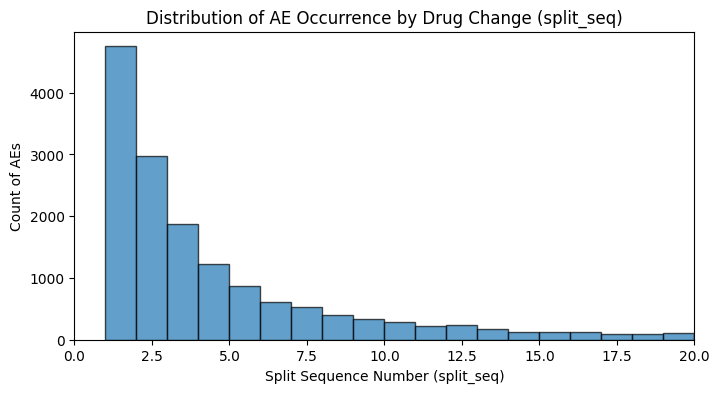

split_seq
1      4751
2      2974
3      1868
4      1222
5       863
       ... 
103       1
109       2
121       1
132       1
146       1
Name: count, Length: 94, dtype: int64


In [11]:
# --- 3. At which drug change does AE occur (split_seq) ---

# Filter split spells that had an AE
ae_spells = df[df['had_ae'] == True]

# Distribution of AE occurrence by split_seq
plt.figure(figsize=(8,4))
plt.hist(ae_spells['split_seq'], bins=range(1, ae_spells['split_seq'].max()+2), edgecolor='black', alpha=0.7)
plt.xlabel('Split Sequence Number (split_seq)')
plt.ylabel('Count of AEs')
plt.xlim(0, 20)
plt.title('Distribution of AE Occurrence by Drug Change (split_seq)')
plt.show()

# Summary
print(ae_spells['split_seq'].value_counts().sort_index())


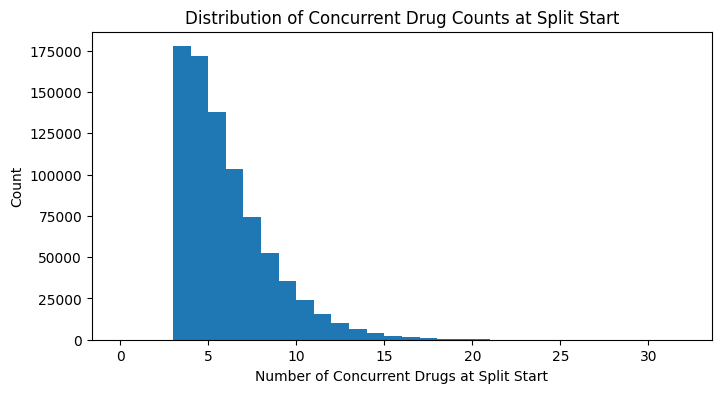

Total distinct individual drugs across all splits: 200


In [ ]:
# --- 4. Derive concurrent drug combos at split start ---

# Number of concurrent drugs at split start
df["concurrent_drugs"] = df["drug_combo"].apply(len)

# Simple histogram, coloured by AE / non-AE
plt.figure(figsize=(8, 4))
plt.hist(df["concurrent_drugs"], bins=range(0, df["concurrent_drugs"].max() + 2))
plt.xlabel("Number of Concurrent Drugs at Split Start")
plt.ylabel("Count")
plt.title("Distribution of Concurrent Drug Counts at Split Start")
plt.show()

plt.savefig("results/plots/drug_counts_split_start.png")

# Number of distinct individual drugs across all splits
all_drugs = set(chain.from_iterable(df["drug_combo"]))
print(f"Total distinct individual drugs across all splits: {len(all_drugs)}")

count    207388.000000
mean         21.633344
std          25.297179
min           0.000000
25%           1.000000
50%          14.000000
75%          31.000000
max         260.000000
Name: n_codes, dtype: float64

icd10_codes
I10    80616
M54    72598
Z79    70096
E78    65822
M25    64229
Z68    63729
M79    56113
Z01    55201
G89    48352
Z00    46751
Z12    45866
R10    45770
F41    45373
Z23    44684
K21    42221
E66    41873
R06    39984
E11    38756
Z87    38621
R07    38359
Name: count, dtype: int64

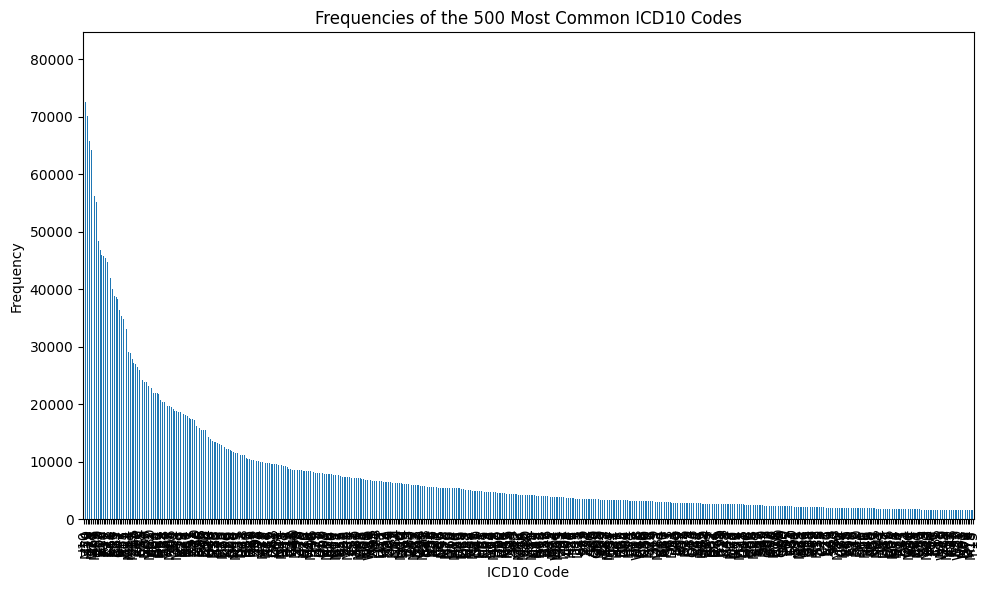

Total distinct ICD10 codes in dataset: 1987


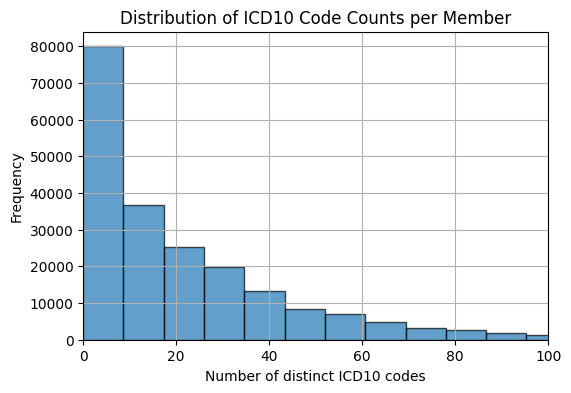

In [ ]:
# Show the comorbidities per patient
# Group by MemberUID and collapse to distinct ICD10 codes per member
member_icd = (
    df
    .explode("icd10_codes")               # one code per row
    .drop_duplicates(["MemberUID", "icd10_codes"])
)

# --- Descriptive statistics ---

# 1. Count of unique ICD10 codes per member
code_counts = (
    member_icd.groupby("MemberUID")["icd10_codes"]
    .nunique()
    .rename("n_codes")
)
display(code_counts.describe())

# 2. Most common ICD10 codes overall
common_codes = (
    member_icd["icd10_codes"]
    .value_counts()
    .head(20)
)
display(common_codes)

# Plot the frequencies of the 500 most common ICD10 codes
plt.figure(figsize=(10, 6))
common_500 = (
    member_icd["icd10_codes"]
    .value_counts()
    .head(500)
)
common_500.plot(kind='bar')
plt.title("Frequencies of the 500 Most Common ICD10 Codes")
plt.xlabel("ICD10 Code")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Amount of distinct ICD10 codes in all the dataset, no grouping per member
distinct_icd10_codes = member_icd["icd10_codes"].nunique()
print(f"Total distinct ICD10 codes in dataset: {distinct_icd10_codes}")


# 3. Distribution of number of codes per member
import matplotlib.pyplot as plt

# Suppress x-axis labels for clarity
plt.figure(figsize=(6,4))
code_counts.hist(bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Number of distinct ICD10 codes")
plt.ylabel("Frequency")
plt.xlim(0,100)
plt.title("Distribution of ICD10 Code Counts per Member")
plt.show()

plt.savefig("results/plots/icd10_codes_per_member.png")


📊 Demographics Summary
------------------------------------------------------------
AE patients: 12,878
Non-AE patients: 205,303
------------------------------------------------------------


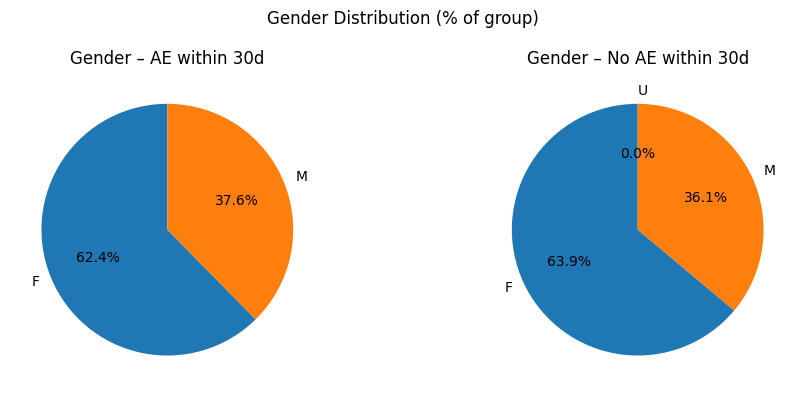

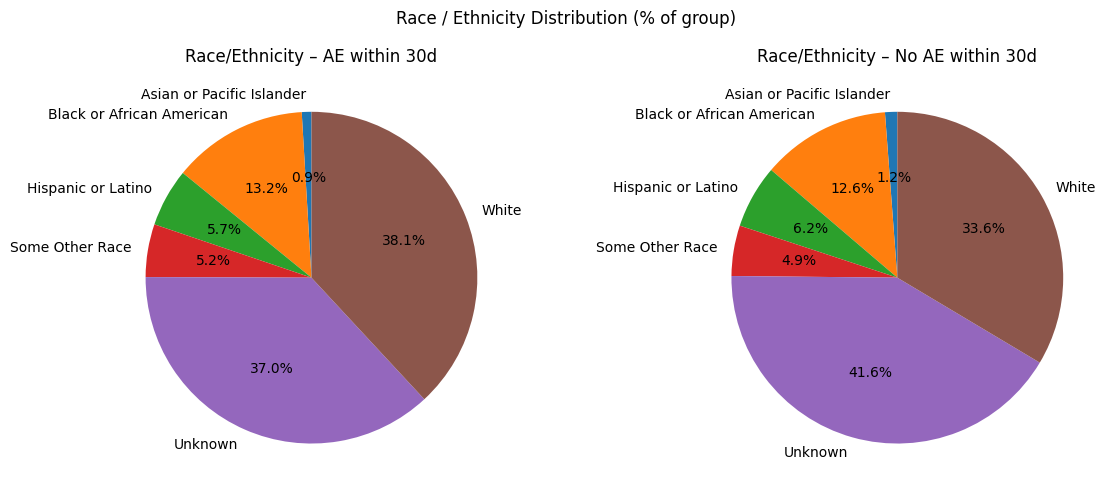

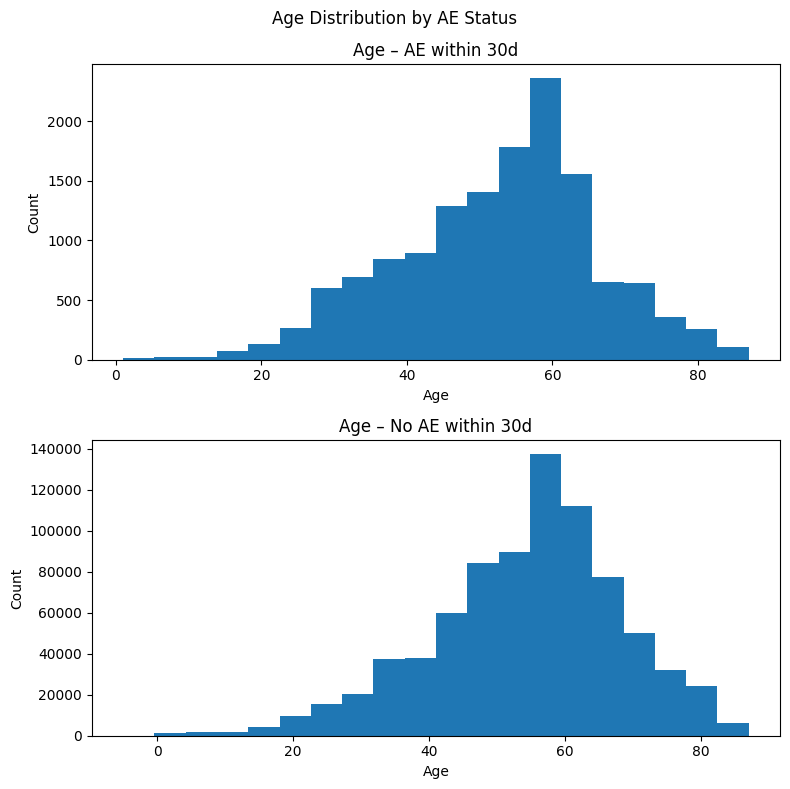

In [ ]:
# --- 👥 Demographics Comparison: AE vs Non-AE ---

ae_spells = df[df["ae_within_30d"]].copy()
non_ae_spells = df[~df["ae_within_30d"]].copy()

print(f"\n📊 Demographics Summary")
print("-" * 60)
print(f"AE patients: {len(ae_spells['MemberUID'].unique()):,}")
print(f"Non-AE patients: {len(non_ae_spells['MemberUID'].unique()):,}")
print("-" * 60)

# ====================================================
# 1) GENDER DISTRIBUTION – PIE CHARTS
# ====================================================

gender_ae = (
    ae_spells["gendercode"]
    .value_counts(normalize=True)
    .sort_index() * 100
)
gender_non = (
    non_ae_spells["gendercode"]
    .value_counts(normalize=True)
    .sort_index() * 100
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].pie(
    gender_ae.values,
    labels=gender_ae.index,
    autopct="%1.1f%%",
    startangle=90
)
axes[0].set_title("Gender – AE within 30d")

axes[1].pie(
    gender_non.values,
    labels=gender_non.index,
    autopct="%1.1f%%",
    startangle=90
)
axes[1].set_title("Gender – No AE within 30d")

plt.suptitle("Gender Distribution (% of group)")
plt.tight_layout()
plt.show()

# Save to results/plots
plt.savefig("results/plots/gender_distribution.png")

# ====================================================
# 2) RACE / ETHNICITY DISTRIBUTION – PIE CHARTS
#    (with code → label mapping)
# ====================================================

race_map = {
    "01": "White",
    "02": "Black or African American",
    "04": "Asian or Pacific Islander",
    "06": "Some Other Race",
    "09": "Unknown",
    "11": "Hispanic or Latino",
}

# Map codes to labels; anything unmapped goes into "Other/Unmapped"
ae_spells["race_label"] = (
    ae_spells["raceethnicitytypecode"]
    .astype(str)
    .map(race_map)
    .fillna("Other/Unmapped")
)
non_ae_spells["race_label"] = (
    non_ae_spells["raceethnicitytypecode"]
    .astype(str)
    .map(race_map)
    .fillna("Other/Unmapped")
)

race_ae = (
    ae_spells["race_label"]
    .value_counts(normalize=True) * 100
)
race_non = (
    non_ae_spells["race_label"]
    .value_counts(normalize=True) * 100
)

# Align categories so AE / Non-AE pies have same ordering
race_index = sorted(set(race_ae.index).union(race_non.index))
race_ae = race_ae.reindex(race_index, fill_value=0)
race_non = race_non.reindex(race_index, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].pie(
    race_ae.values,
    labels=race_ae.index,
    autopct="%1.1f%%",
    startangle=90
)
axes[0].set_title("Race/Ethnicity – AE within 30d")

axes[1].pie(
    race_non.values,
    labels=race_non.index,
    autopct="%1.1f%%",
    startangle=90
)
axes[1].set_title("Race/Ethnicity – No AE within 30d")

plt.suptitle("Race / Ethnicity Distribution (% of group)")
plt.tight_layout()
plt.show()

plt.savefig("results/plots/race_distribution.png")

# ====================================================
# 3) AGE HISTOGRAM (AE vs Non-AE) – VERTICAL, SEPARATE AXES
# ====================================================
age_col = "age"  # change if your age column has a different name
bins = 20        # or e.g. np.arange(0, 100, 5)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))  # no sharex/sharey

# Top: AE within 30d
axes[0].hist(ae_spells[age_col], bins=bins)
axes[0].set_title("Age – AE within 30d")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

# Bottom: No AE within 30d
axes[1].hist(non_ae_spells[age_col], bins=bins)
axes[1].set_title("Age – No AE within 30d")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Count")

fig.suptitle("Age Distribution by AE Status", y=0.98)
plt.tight_layout()
plt.show()


plt.savefig("results/plots/age_distribution.png")

In [2]:
import pandas as pd
from pathlib import Path

# =========================================================
# 0. Setup
# =========================================================
out_dir = Path("results/tables")
out_dir.mkdir(parents=True, exist_ok=True)

# df: one row per spell, with columns:
#   MemberUID, age, gendercode, raceethnicitytypecode,
#   ae_within_30d (bool), icd10_codes (list of codes)

# =========================================================
# 1. Pre-compute helpers on the full spell dataframe
# =========================================================

# Count distinct ICD10 codes per spell
def count_icd_list(x):
    if isinstance(x, (list, set, tuple)):
        return len(set(x))
    if pd.isna(x):
        return 0
    # if it's a single code as a string
    return 1

df["n_icd10_codes"] = df["icd10_codes"].apply(count_icd_list)

# Map race codes → labels
race_map = {
    "01": "White",
    "02": "Black or African American",
    "04": "Asian or Pacific Islander",
    "06": "Some Other Race",
    "09": "Unknown",
    "11": "Hispanic or Latino",
}
df["race_label"] = (
    df["raceethnicitytypecode"]
    .astype(str)
    .map(race_map)
    .fillna("Other/Unmapped")
)

# Split spells into AE / non-AE
ae_spells = df[df["ae_within_30d"]].copy()
non_ae_spells = df[~df["ae_within_30d"]].copy()

# =========================================================
# 2. Function to summarize one spell group
# =========================================================

def summarize_spells(g: pd.DataFrame) -> dict:
    out = {}
    out["N spells"] = f"{len(g):,}"
    out["N patients"] = f"{g['MemberUID'].nunique():,}"

    # Age: median [IQR]
    q1, q2, q3 = g["age"].quantile([0.25, 0.5, 0.75])
    out["Age, median [IQR]"] = f"{q2:.1f} [{q1:.1f}, {q3:.1f}]"

    # Gender %
    for code, label in [("F", "Female, %"), ("M", "Male, %")]:
        pct = (g["gendercode"] == code).mean() * 100
        out[label] = f"{pct:.1f}"
    other_pct = (~g["gendercode"].isin(["F", "M"])).mean() * 100
    out["Other/Unknown gender, %"] = f"{other_pct:.1f}"

    # Race %
    for label in [
        "White",
        "Black or African American",
        "Hispanic or Latino",
        "Asian or Pacific Islander",
        "Some Other Race",
        "Unknown",
    ]:
        pct = (g["race_label"] == label).mean() * 100
        out[f"{label}, %"] = f"{pct:.1f}"

    # Distinct ICD10 codes per spell: median [IQR]
    q1, q2, q3 = g["n_icd10_codes"].quantile([0.25, 0.5, 0.75])
    out["Distinct ICD10 codes per spell, median [IQR]"] = f"{q2:.0f} [{q1:.0f}, {q3:.0f}]"

    return out

# =========================================================
# 3. Build summary table and save as LaTeX
# =========================================================

summary = pd.DataFrame({
    "AE within 30d": summarize_spells(ae_spells),
    "No AE within 30d": summarize_spells(non_ae_spells),
})

tex_path = out_dir / "table1_spell_baseline.tex"
summary.to_latex(tex_path, escape=False)  # keep % and [ ] as-is

print("✅ Table 1 written to:", tex_path)
display(summary)


✅ Table 1 written to: results/tables/table1_spell_baseline.tex


,AE within 30d,No AE within 30d
N spells,"13,959","804,423"
N patients,"12,878","205,303"
"Age, median [IQR]","54.0 [43.0, 62.0]","56.0 [46.0, 63.0]"
"Female, %",62.4,63.9
"Male, %",37.6,36.1
"Other/Unknown gender, %",0.0,0.0
"White, %",38.1,33.6
"Black or African American, %",13.2,12.6
"Hispanic or Latino, %",5.7,6.2
"Asian or Pacific Islander, %",0.9,1.2
